# Sign Language Quiz

### Authors:  
- <span style="color:lightblue;">Avanthi Narasingu - 1RVU22CSE032</span>  
- <span style="color:lightblue;">Reethu RG Thota - 1RVU22CSE128</span>  
- <span style="color:lightblue;">Shreyas Rajiv - 1RVU22CSE153</span>

### Guide:
<span style="color:lightblue;"> **Dr.Shobana Padmanabhan**</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found.")

Num GPUs Available: 1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
import csv
import warnings
import logging
from tqdm import tqdm

# Suppress specific warnings from Mediapipe
warnings.filterwarnings("ignore", category=UserWarning, module='mediapipe')
logging.getLogger('mediapipe').setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

class HandTrackingDynamic:
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        self.__mode__ = mode
        self.__maxHands__ = maxHands
        self.__detectionCon__ = detectionCon
        self.__trackCon__ = trackCon
        self.handsMp = mp.solutions.hands
        self.hands = self.handsMp.Hands(
            static_image_mode=mode,
            max_num_hands=maxHands,
            min_detection_confidence=detectionCon,
            min_tracking_confidence=trackCon
        )
        self.mpDraw = mp.solutions.drawing_utils

    def findFingers(self, frame, draw=True):
        imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        if self.results.multi_hand_landmarks and draw:
            for handLms in self.results.multi_hand_landmarks:
                self.mpDraw.draw_landmarks(frame, handLms, self.handsMp.HAND_CONNECTIONS)
        return frame

    def findPosition(self, frame):
        h, w, _ = frame.shape
        left_hand = np.zeros((21, 3))
        right_hand = np.zeros((21, 3))

        if self.results.multi_hand_landmarks:
            for hand_landmarks, hand_handedness in zip(self.results.multi_hand_landmarks, self.results.multi_handedness):
                is_right = hand_handedness.classification[0].label == "Right"
                hand_data = np.array([[lm.x * w, lm.y * h, lm.z] for lm in hand_landmarks.landmark])

                if is_right:
                    right_hand = hand_data
                else:
                    left_hand = hand_data

        return np.concatenate([left_hand.flatten(), right_hand.flatten()])

def extract_hand_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    detector = HandTrackingDynamic(maxHands=2)
    landmarks_list = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detector.findFingers(frame, draw=False)
        landmarks = detector.findPosition(frame)

        if landmarks is not None:
            landmarks_list.append(landmarks)

    cap.release()
    return landmarks_list

def create_sequences(landmarks, timesteps=30):
    sequences = []
    landmarks = np.array(landmarks)

    if len(landmarks) >= timesteps:
        for i in range(len(landmarks) - timesteps + 1):
            seq = landmarks[i:i + timesteps]
            sequences.append(seq)

    return np.array(sequences)

def process_videos_from_csv(csv_file, video_folder, timesteps=30):
    processed_folder = '/Users/reethu/coding/Projects/Sign-Language-Quiz/WLASL/processed_landmarks_from_csv'
    os.makedirs(processed_folder, exist_ok=True)

    # Get list of already processed files
    existing_files = set(os.listdir(processed_folder))

    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        total_videos = sum(1 for row in reader) - 1  # Exclude header row
        file.seek(0)  # Reset reader position to start after counting

        processed_count = 0
        skipped_count = 0

        # Use tqdm for progress bar
        next(reader)  # Skip header row
        for row in tqdm(reader, desc="Processing videos"):
            gloss, video_id = row
            expected_output_file = f"{gloss.replace(' ', '_')}_{video_id}.npy"

            if expected_output_file in existing_files:
                skipped_count += 1
                continue

            video_path = os.path.join(video_folder, f"{video_id}.mp4")

            if os.path.exists(video_path):
                landmarks = extract_hand_landmarks(video_path)

                if landmarks:
                    sequences = create_sequences(landmarks, timesteps)

                    if len(sequences) > 0:
                        processed_file_path = os.path.join(
                            processed_folder,
                            expected_output_file
                        )
                        np.save(processed_file_path, sequences)
                        processed_count += 1

                        print(f"\rProcessed: {processed_count}, Skipped: {skipped_count}, "
                              f"Total: {total_videos}", end="")

    print(f"\nProcessing complete!")
    print(f"Total videos: {total_videos}")
    print(f"Already processed (skipped): {skipped_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Total processed: {skipped_count + processed_count}")

if __name__ == "__main__":
    csv_file = "/Users/reethu/coding/Projects/Sign-Language-Quiz/WLASL/sorted_100.csv"
    video_folder = "/Users/reethu/coding/Projects/Sign-Language-Quiz/WLASL/WLASL_dataset/videos"
    process_videos_from_csv(csv_file, video_folder)


Processing videos: 0it [00:00, ?it/s]I0000 00:00:1732715987.294684  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732715987.304041  613227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732715987.309041  613230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/reethu/Applications/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing videos: 15it [00:00, 15.10it/s]I0000 00:00:1732715988.294164  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer

Processed: 1, Skipped: 885, Total: 1120

I0000 00:00:1732716029.522290  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716029.528202  614390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716029.533792  614390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 2, Skipped: 885, Total: 1120

I0000 00:00:1732716030.874513  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716030.880707  614422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716030.885868  614422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 942it [00:44,  7.01it/s]

Processed: 3, Skipped: 885, Total: 1120

I0000 00:00:1732716032.231270  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716032.237042  614449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716032.241679  614449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1732716032.922390  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716032.928149  614477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716032.936841  614477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 944it [00:46,  5.58it

Processed: 4, Skipped: 885, Total: 1120

I0000 00:00:1732716033.812853  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716033.819095  614496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716033.824660  614496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed: 5, Skipped: 885, Total: 1120

I0000 00:00:1732716035.788058  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716035.794060  614526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716035.800037  614532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 946it [00:50,  3.14it/s]

Processed: 6, Skipped: 885, Total: 1120

I0000 00:00:1732716037.893108  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716037.898593  614560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716037.904478  614561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 947it [00:52,  2.55it/s]

Processed: 7, Skipped: 885, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716039.671964  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716039.739733  614592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716039.747204  614592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 948it [00:53,  2.29it/s]

Processed: 8, Skipped: 885, Total: 1120

I0000 00:00:1732716040.708995  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716040.715207  614615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716040.719589  614615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 949it [00:54,  2.05it/s]

Processed: 9, Skipped: 885, Total: 1120

I0000 00:00:1732716041.718787  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716041.723883  614636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716041.728401  614636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 950it [00:56,  1.59it/s]

Processed: 10, Skipped: 885, Total: 1120

I0000 00:00:1732716043.453468  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716043.458488  614660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716043.462986  614660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 951it [00:57,  1.36it/s]

Processed: 11, Skipped: 885, Total: 1120

I0000 00:00:1732716044.871308  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716044.877335  614680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716044.883008  614680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 952it [00:58,  1.29it/s]

Processed: 12, Skipped: 885, Total: 1120

I0000 00:00:1732716045.858802  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716045.864688  614700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716045.869352  614700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 953it [00:59,  1.15it/s]

Processed: 13, Skipped: 885, Total: 1120

I0000 00:00:1732716047.128390  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716047.134929  614724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716047.147644  614724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 954it [01:01,  1.06it/s]

Processed: 14, Skipped: 885, Total: 1120

I0000 00:00:1732716048.338946  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716048.346566  614743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716048.351300  614743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 955it [01:02,  1.12s/it]

Processed: 15, Skipped: 885, Total: 1120

I0000 00:00:1732716050.026538  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716050.031936  614764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716050.037552  614763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 956it [01:04,  1.29s/it]

Processed: 16, Skipped: 885, Total: 1120

I0000 00:00:1732716051.863590  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716051.872850  614784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716051.885868  614784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 957it [01:05,  1.30s/it]

Processed: 17, Skipped: 885, Total: 1120

I0000 00:00:1732716053.166395  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716053.173131  614802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716053.184456  614806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 958it [01:07,  1.40s/it]

Processed: 18, Skipped: 885, Total: 1120

I0000 00:00:1732716054.849457  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716054.856908  614821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716054.862189  614821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 959it [01:10,  1.73s/it]

Processed: 19, Skipped: 885, Total: 1120

I0000 00:00:1732716057.407157  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716057.413677  614853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716057.422853  614856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 960it [01:10,  1.45s/it]I0000 00:00:1732716058.165861  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716058.170932  614883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716058.174765  614879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensor

Processed: 20, Skipped: 885, Total: 1120

I0000 00:00:1732716059.554201  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716059.559357  614917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716059.564471  614917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 962it [01:14,  1.55s/it]

Processed: 21, Skipped: 885, Total: 1120

I0000 00:00:1732716061.373016  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716061.378575  615011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716061.384251  615011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 963it [01:15,  1.64s/it]

Processed: 22, Skipped: 885, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716063.231021  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716063.237165  615052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716063.244727  615052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 964it [01:17,  1.48s/it]

Processed: 23, Skipped: 885, Total: 1120

I0000 00:00:1732716064.339185  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716064.345401  615099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716064.350308  615099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 965it [01:18,  1.40s/it]

Processed: 24, Skipped: 885, Total: 1120

I0000 00:00:1732716065.532053  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716065.537190  615130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716065.542250  615130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 966it [01:19,  1.30s/it]

Processed: 25, Skipped: 885, Total: 1120

I0000 00:00:1732716066.623971  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716066.633050  615173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716066.643610  615173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 967it [01:20,  1.27s/it]

Processed: 26, Skipped: 885, Total: 1120

I0000 00:00:1732716067.806516  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716067.812440  615190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716067.818994  615190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 968it [01:21,  1.26s/it]

Processed: 27, Skipped: 885, Total: 1120

I0000 00:00:1732716069.046173  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716069.051147  615214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716069.063647  615214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 969it [01:22,  1.22s/it]

Processed: 28, Skipped: 885, Total: 1120

I0000 00:00:1732716070.176167  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716070.181443  615232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716070.185353  615232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 970it [01:25,  1.53s/it]

Processed: 29, Skipped: 885, Total: 1120

I0000 00:00:1732716072.429376  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716072.434895  615271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716072.439170  615271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 971it [01:26,  1.39s/it]

Processed: 30, Skipped: 885, Total: 1120

I0000 00:00:1732716073.488074  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716073.494288  615290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716073.499012  615296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 972it [01:27,  1.34s/it]

Processed: 31, Skipped: 885, Total: 1120

I0000 00:00:1732716074.718024  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716074.728499  615331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716074.740382  615331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 973it [01:29,  1.44s/it]

Processed: 32, Skipped: 885, Total: 1120

I0000 00:00:1732716076.392997  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716076.398444  615399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716076.403234  615399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 974it [01:32,  2.15s/it]

Processed: 33, Skipped: 885, Total: 1120

I0000 00:00:1732716080.195744  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716080.201637  615421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716080.208136  615427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 975it [01:34,  1.97s/it]

Processed: 34, Skipped: 885, Total: 1120

I0000 00:00:1732716081.749579  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716081.756446  615445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716081.775914  615445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 976it [01:38,  2.52s/it]

Processed: 35, Skipped: 885, Total: 1120

I0000 00:00:1732716085.533388  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716085.538956  615478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716085.544129  615478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 977it [01:39,  2.09s/it]

Processed: 36, Skipped: 885, Total: 1120

I0000 00:00:1732716086.633959  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716086.641319  615510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716086.665728  615512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 978it [01:41,  2.03s/it]

Processed: 37, Skipped: 885, Total: 1120

I0000 00:00:1732716088.531920  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716088.539015  615592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716088.543811  615592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 979it [01:43,  1.99s/it]

Processed: 38, Skipped: 885, Total: 1120

I0000 00:00:1732716090.415600  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716090.422099  615615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716090.434530  615615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 980it [01:45,  2.08s/it]

Processed: 39, Skipped: 885, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716092.697601  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716092.707821  615648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716092.712862  615648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 981it [01:47,  2.03s/it]

Processed: 40, Skipped: 885, Total: 1120

I0000 00:00:1732716094.631532  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716094.636431  615691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716094.640914  615691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 982it [01:48,  1.68s/it]

Processed: 41, Skipped: 885, Total: 1120

I0000 00:00:1732716095.482267  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716095.488287  615710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716095.495192  615710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 983it [01:52,  2.49s/it]

Processed: 42, Skipped: 885, Total: 1120

I0000 00:00:1732716099.856962  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716099.863079  615766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716099.871613  615766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 984it [01:54,  2.19s/it]

Processed: 43, Skipped: 885, Total: 1120

I0000 00:00:1732716101.338346  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716101.346517  615796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716101.352455  615796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 985it [01:56,  2.28s/it]

Processed: 44, Skipped: 885, Total: 1120

I0000 00:00:1732716103.855272  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716103.863460  615848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716103.875879  615848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 986it [01:58,  2.32s/it]

Processed: 45, Skipped: 885, Total: 1120

I0000 00:00:1732716106.263720  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716106.270063  615891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716106.275849  615891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 987it [02:00,  1.95s/it]

Processed: 46, Skipped: 885, Total: 1120

I0000 00:00:1732716107.329444  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716107.337988  615922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716107.349630  615922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 988it [02:02,  2.08s/it]

Processed: 47, Skipped: 885, Total: 1120

I0000 00:00:1732716109.722315  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716109.728970  615960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716109.734275  615960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 989it [02:04,  2.02s/it]

Processed: 48, Skipped: 885, Total: 1120

I0000 00:00:1732716111.590717  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716111.596257  615979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716111.608656  615979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 990it [02:06,  2.01s/it]

Processed: 49, Skipped: 885, Total: 1120

I0000 00:00:1732716113.597977  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716113.604821  616023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716113.612754  616023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 991it [02:08,  1.99s/it]

Processed: 50, Skipped: 885, Total: 1120

I0000 00:00:1732716115.541358  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716115.547522  616063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716115.554529  616063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 992it [02:09,  1.68s/it]

Processed: 51, Skipped: 885, Total: 1120

I0000 00:00:1732716116.499433  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716116.505866  616089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716116.514793  616092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 993it [02:10,  1.59s/it]

Processed: 52, Skipped: 885, Total: 1120

I0000 00:00:1732716117.884274  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716117.890699  616137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716117.896537  616137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 994it [02:12,  1.54s/it]

Processed: 53, Skipped: 885, Total: 1120

I0000 00:00:1732716119.294738  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716119.301125  616164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716119.309632  616164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 995it [02:13,  1.52s/it]

Processed: 54, Skipped: 885, Total: 1120

I0000 00:00:1732716120.772397  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716120.778390  616194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716120.792353  616194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 996it [02:14,  1.47s/it]

Processed: 55, Skipped: 885, Total: 1120

I0000 00:00:1732716122.133082  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716122.139443  616215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716122.144577  616215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 997it [02:15,  1.37s/it]

Processed: 56, Skipped: 885, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716123.254672  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716123.261190  616240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716123.265994  616240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 998it [02:17,  1.30s/it]

Processed: 57, Skipped: 885, Total: 1120

I0000 00:00:1732716124.410986  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716124.422039  616263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716124.434690  616261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 999it [02:18,  1.37s/it]

Processed: 58, Skipped: 885, Total: 1120

I0000 00:00:1732716125.929869  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716125.936573  616282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716125.943642  616282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1000it [02:19,  1.32s/it]

Processed: 59, Skipped: 885, Total: 1120

I0000 00:00:1732716127.125889  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716127.132356  616306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716127.137234  616306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1001it [02:21,  1.28s/it]

Processed: 60, Skipped: 885, Total: 1120

I0000 00:00:1732716128.328770  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716128.335008  616321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716128.340906  616322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1002it [02:22,  1.42s/it]

Processed: 61, Skipped: 885, Total: 1120

I0000 00:00:1732716130.060210  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716130.066999  616356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716130.078250  616356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1003it [02:24,  1.62s/it]

Processed: 62, Skipped: 885, Total: 1120

I0000 00:00:1732716132.139357  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716132.145722  616382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716132.150758  616382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1004it [02:26,  1.59s/it]

Processed: 63, Skipped: 885, Total: 1120

I0000 00:00:1732716133.696666  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716133.703991  616401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716133.718312  616401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1005it [02:27,  1.48s/it]

Processed: 64, Skipped: 885, Total: 1120

I0000 00:00:1732716134.883928  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716134.889613  616422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716134.894838  616422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1006it [02:29,  1.66s/it]

Processed: 65, Skipped: 885, Total: 1120

I0000 00:00:1732716136.965283  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716136.971296  616489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716136.976402  616489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1007it [02:31,  1.69s/it]

Processed: 66, Skipped: 885, Total: 1120

I0000 00:00:1732716138.741930  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716138.748325  616516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716138.754318  616516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1008it [02:32,  1.58s/it]

Processed: 67, Skipped: 885, Total: 1120

I0000 00:00:1732716140.062720  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716140.068503  616549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716140.073144  616549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1009it [02:34,  1.59s/it]

Processed: 68, Skipped: 885, Total: 1120

I0000 00:00:1732716141.663061  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716141.669929  616589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716141.677794  616589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1010it [02:35,  1.48s/it]

Processed: 69, Skipped: 885, Total: 1120

I0000 00:00:1732716142.881204  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716142.887121  616617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716142.892370  616617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1011it [02:37,  1.68s/it]

Processed: 70, Skipped: 885, Total: 1120

I0000 00:00:1732716145.034187  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716145.040790  616666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716145.048392  616666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1012it [02:38,  1.46s/it]

Processed: 71, Skipped: 885, Total: 1120

I0000 00:00:1732716145.967757  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716145.973491  616681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716145.985455  616681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1013it [02:40,  1.48s/it]

Processed: 72, Skipped: 885, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716147.498499  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716147.503871  616721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716147.509311  616721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1014it [02:43,  2.09s/it]

Processed: 73, Skipped: 885, Total: 1120

I0000 00:00:1732716151.015652  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716151.021628  616762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716151.028220  616762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1015it [02:46,  2.15s/it]

Processed: 74, Skipped: 885, Total: 1120

I0000 00:00:1732716153.330399  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716153.337073  616787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716153.354363  616787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1016it [02:47,  1.87s/it]

Processed: 75, Skipped: 885, Total: 1120

I0000 00:00:1732716154.513928  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716154.518994  616812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716154.523853  616812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1017it [02:49,  2.06s/it]

Processed: 76, Skipped: 885, Total: 1120

I0000 00:00:1732716157.039905  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716157.045800  616839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716157.050371  616839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1018it [02:51,  2.11s/it]

Processed: 77, Skipped: 885, Total: 1120

I0000 00:00:1732716159.255895  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716159.262698  616860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716159.270431  616860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1019it [02:52,  1.76s/it]

Processed: 78, Skipped: 885, Total: 1120

I0000 00:00:1732716160.209053  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716160.214513  616897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716160.219228  616896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1020it [02:54,  1.57s/it]

Processed: 79, Skipped: 885, Total: 1120

I0000 00:00:1732716161.330947  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716161.336125  616925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716161.340994  616925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1021it [02:56,  1.91s/it]

Processed: 80, Skipped: 885, Total: 1120

I0000 00:00:1732716164.040668  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716164.046593  617035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716164.052978  617035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1022it [02:58,  1.75s/it]

Processed: 81, Skipped: 885, Total: 1120

I0000 00:00:1732716165.408122  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716165.414344  617064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716165.419581  617064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1023it [02:59,  1.60s/it]

Processed: 82, Skipped: 885, Total: 1120

I0000 00:00:1732716166.669895  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716166.675641  617083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716166.683495  617083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1024it [03:00,  1.55s/it]

Processed: 83, Skipped: 885, Total: 1120

I0000 00:00:1732716168.090271  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716168.124498  617118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716168.134364  617118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1025it [03:02,  1.65s/it]

Processed: 84, Skipped: 885, Total: 1120

I0000 00:00:1732716169.983221  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716169.989307  617142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716169.997058  617143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1026it [03:04,  1.73s/it]

Processed: 85, Skipped: 885, Total: 1120

I0000 00:00:1732716171.908848  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716171.916034  617204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716171.922877  617204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1034it [03:05,  2.17it/s]I0000 00:00:1732716172.626741  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716172.633358  617227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716172.638952  617227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tenso

Processed: 86, Skipped: 902, Total: 1120

I0000 00:00:1732716176.721611  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716176.727049  617330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716176.731563  617330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1050it [03:10,  2.53it/s]

Processed: 87, Skipped: 902, Total: 1120

I0000 00:00:1732716177.662016  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716177.667880  617352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716177.673099  617352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1051it [03:11,  2.15it/s]I0000 00:00:1732716178.519645  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716178.525492  617371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716178.529988  617371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tenso

Processed: 88, Skipped: 902, Total: 1120

I0000 00:00:1732716180.428533  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716180.434310  617392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716180.438698  617392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1053it [03:14,  1.24it/s]

Processed: 89, Skipped: 902, Total: 1120

I0000 00:00:1732716181.560861  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716181.565503  617415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716181.572982  617415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1054it [03:15,  1.07it/s]

Processed: 90, Skipped: 902, Total: 1120

I0000 00:00:1732716182.953036  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716182.958584  617432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716182.962984  617432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1055it [03:17,  1.04s/it]

Processed: 91, Skipped: 902, Total: 1120

I0000 00:00:1732716184.306020  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716184.311805  617450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716184.317332  617453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1056it [03:19,  1.31s/it]

Processed: 92, Skipped: 902, Total: 1120

I0000 00:00:1732716186.393924  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716186.399617  617475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716186.404788  617475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1057it [03:21,  1.57s/it]

Processed: 93, Skipped: 902, Total: 1120

I0000 00:00:1732716188.683660  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716188.690868  617493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716188.702963  617493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1058it [03:23,  1.73s/it]

Processed: 94, Skipped: 902, Total: 1120

I0000 00:00:1732716190.843144  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716190.849014  617517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716190.853030  617517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1070it [03:24,  2.60it/s]

Processed: 95, Skipped: 913, Total: 1120

I0000 00:00:1732716192.062199  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716192.069531  617543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716192.079740  617547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1071it [03:26,  2.00it/s]

Processed: 96, Skipped: 913, Total: 1120

I0000 00:00:1732716193.744311  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716193.750974  617563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716193.762163  617567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1072it [03:28,  1.46it/s]

Processed: 97, Skipped: 913, Total: 1120

I0000 00:00:1732716195.847435  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716195.853378  617587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716195.858856  617587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1073it [03:29,  1.35it/s]

Processed: 98, Skipped: 913, Total: 1120

I0000 00:00:1732716196.939521  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716196.945081  617624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716196.949095  617624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1074it [03:31,  1.03it/s]

Processed: 99, Skipped: 913, Total: 1120

I0000 00:00:1732716199.086648  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716199.092327  617654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716199.098702  617654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1075it [03:33,  1.05s/it]

Processed: 100, Skipped: 913, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716200.438694  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716200.444528  617671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716200.450644  617671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1076it [03:34,  1.08s/it]

Processed: 101, Skipped: 913, Total: 1120

I0000 00:00:1732716201.628355  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716201.634485  617690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716201.640309  617690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1077it [03:35,  1.20s/it]

Processed: 102, Skipped: 913, Total: 1120

I0000 00:00:1732716203.234367  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716203.240230  617723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716203.244957  617723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1078it [03:37,  1.21s/it]

Processed: 103, Skipped: 913, Total: 1120

I0000 00:00:1732716204.485106  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716204.491416  617740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716204.500704  617736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1079it [03:38,  1.18s/it]

Processed: 104, Skipped: 913, Total: 1120

I0000 00:00:1732716205.578453  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716205.584752  617757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716205.590583  617757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1080it [03:39,  1.21s/it]

Processed: 105, Skipped: 913, Total: 1120

I0000 00:00:1732716206.876976  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716206.882206  617787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716206.886144  617787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1081it [03:40,  1.22s/it]

Processed: 106, Skipped: 913, Total: 1120

I0000 00:00:1732716208.112249  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716208.117228  617810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716208.121488  617810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1082it [03:42,  1.47s/it]

Processed: 107, Skipped: 913, Total: 1120

I0000 00:00:1732716210.218706  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716210.223806  617835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716210.228287  617835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1083it [03:44,  1.63s/it]

Processed: 108, Skipped: 913, Total: 1120

I0000 00:00:1732716212.219133  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716212.224383  617862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716212.230401  617862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1084it [03:46,  1.56s/it]

Processed: 109, Skipped: 913, Total: 1120

I0000 00:00:1732716213.602585  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716213.608049  617881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716213.613179  617881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1085it [03:47,  1.39s/it]

Processed: 110, Skipped: 913, Total: 1120

I0000 00:00:1732716214.588263  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716214.593422  617904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716214.598283  617904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1086it [03:49,  1.56s/it]

Processed: 111, Skipped: 913, Total: 1120

I0000 00:00:1732716216.568122  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716216.574955  617927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716216.579802  617927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1087it [03:50,  1.56s/it]

Processed: 112, Skipped: 913, Total: 1120

I0000 00:00:1732716218.118108  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716218.123456  617943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716218.128502  617943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1088it [03:53,  2.02s/it]

Processed: 113, Skipped: 913, Total: 1120

I0000 00:00:1732716221.218600  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716221.224574  617985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716221.230929  617985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1089it [03:55,  1.99s/it]

Processed: 114, Skipped: 913, Total: 1120

I0000 00:00:1732716223.133168  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716223.139498  618008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716223.144002  618008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1090it [03:57,  1.81s/it]

Processed: 115, Skipped: 913, Total: 1120

I0000 00:00:1732716224.509419  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716224.515684  618028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716224.552051  618028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1091it [03:58,  1.70s/it]

Processed: 116, Skipped: 913, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716225.967655  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716225.974051  618044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716225.987815  618044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1092it [03:59,  1.47s/it]

Processed: 117, Skipped: 913, Total: 1120

I0000 00:00:1732716226.901500  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716226.907386  618070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716226.913028  618070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1093it [04:01,  1.47s/it]

Processed: 118, Skipped: 913, Total: 1120

I0000 00:00:1732716228.359054  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716228.366126  618087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716228.371348  618087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1094it [04:03,  1.63s/it]

Processed: 119, Skipped: 913, Total: 1120

I0000 00:00:1732716230.377853  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716230.384158  618116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716230.390075  618114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1095it [04:05,  1.74s/it]

Processed: 120, Skipped: 913, Total: 1120

I0000 00:00:1732716232.371381  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716232.377538  618139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716232.382738  618139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1096it [04:07,  1.87s/it]

Processed: 121, Skipped: 913, Total: 1120

I0000 00:00:1732716234.555301  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716234.562541  618166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716234.569002  618166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1097it [04:10,  2.36s/it]

Processed: 122, Skipped: 913, Total: 1120

I0000 00:00:1732716238.063268  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716238.069185  618198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716238.074528  618198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1098it [04:11,  1.96s/it]

Processed: 123, Skipped: 913, Total: 1120

I0000 00:00:1732716239.061529  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716239.067121  618215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716239.071831  618215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1099it [04:13,  1.97s/it]

Processed: 124, Skipped: 913, Total: 1120

I0000 00:00:1732716241.061516  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716241.069196  618246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716241.074405  618246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1100it [04:16,  2.09s/it]

Processed: 125, Skipped: 913, Total: 1120

I0000 00:00:1732716243.435087  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716243.440139  618266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716243.444029  618266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1101it [04:17,  1.78s/it]

Processed: 126, Skipped: 913, Total: 1120

I0000 00:00:1732716244.495692  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716244.501031  618288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716244.507430  618292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1102it [04:18,  1.58s/it]

Processed: 127, Skipped: 913, Total: 1120

I0000 00:00:1732716245.585548  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716245.590665  618308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716245.594374  618308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1103it [04:19,  1.34s/it]I0000 00:00:1732716246.362992  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716246.368030  618326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716246.373241  618326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tenso

Processed: 128, Skipped: 913, Total: 1120

I0000 00:00:1732716247.507828  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716247.513154  618349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716247.519400  618350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1105it [04:22,  1.52s/it]

Processed: 129, Skipped: 913, Total: 1120

I0000 00:00:1732716249.606304  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716249.613057  618374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716249.624374  618372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1106it [04:24,  1.64s/it]

Processed: 130, Skipped: 913, Total: 1120

I0000 00:00:1732716251.511533  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716251.520918  618403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716251.533644  618403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1107it [04:26,  1.73s/it]

Processed: 131, Skipped: 913, Total: 1120

I0000 00:00:1732716253.471316  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716253.476661  618427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716253.481684  618427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1108it [04:27,  1.50s/it]

Processed: 132, Skipped: 913, Total: 1120

Context leak detected, msgtracer returned -1
I0000 00:00:1732716254.404213  609865 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732716254.409519  618447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732716254.414694  618447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing videos: 1120it [04:28,  4.17it/s]

Processed: 133, Skipped: 913, Total: 1120
Processing complete!
Total videos: 1120
Already processed (skipped): 924
Newly processed: 133
Total processed: 1057


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Folder path where all the .npy files are stored
npy_folder_path = '/content/drive/MyDrive/Semester 5/DL/Project/processed_landmarks_from_csv'

# Dictionary to store the data grouped by labels
label_video_dict = {}

# Loop through the folder and group data by labels
for npy_file in os.listdir(npy_folder_path):
    if npy_file.endswith('.npy'):
        # Load the data
        data = np.load(os.path.join(npy_folder_path, npy_file))

        print(data.shape)
        # Check if the data has a valid shape
        if data.shape == (0,):
            print(f"Skipping file {npy_file} due to invalid shape {data.shape}")
            continue  # Skip the current file

        # Rescale the data
        reshaped_data = (data - np.min(data)) / (np.max(data) - np.min(data))

        # Extract the label from the file name (assuming label is part of the file name)
        label = npy_file.split('_')[0:-1]  # Adjust as per naming convention
        label = '_'.join(label)  # Join the label parts if there are underscores

        # Append the reshaped data under the corresponding label
        if label not in label_video_dict:
            label_video_dict[label] = []
        label_video_dict[label].append(reshaped_data)

(31, 30, 126)
(16, 30, 126)
(37, 30, 126)
(16, 30, 126)
(16, 30, 126)
(13, 30, 126)
(12, 30, 126)
(79, 30, 126)
(32, 30, 126)
(4, 30, 126)
(34, 30, 126)
(59, 30, 126)
(4, 30, 126)
(31, 30, 126)
(59, 30, 126)
(72, 30, 126)
(43, 30, 126)
(78, 30, 126)
(52, 30, 126)
(14, 30, 126)
(28, 30, 126)
(14, 30, 126)
(24, 30, 126)
(16, 30, 126)
(11, 30, 126)
(73, 30, 126)
(44, 30, 126)
(17, 30, 126)
(34, 30, 126)
(57, 30, 126)
(38, 30, 126)
(7, 30, 126)
(11, 30, 126)
(18, 30, 126)
(32, 30, 126)
(64, 30, 126)
(29, 30, 126)
(126, 30, 126)
(25, 30, 126)
(82, 30, 126)
(16, 30, 126)
(16, 30, 126)
(41, 30, 126)
(50, 30, 126)
(41, 30, 126)
(42, 30, 126)
(42, 30, 126)
(65, 30, 126)
(67, 30, 126)
(77, 30, 126)
(102, 30, 126)
(77, 30, 126)
(30, 30, 126)
(14, 30, 126)
(10, 30, 126)
(43, 30, 126)
(46, 30, 126)
(48, 30, 126)
(42, 30, 126)
(29, 30, 126)
(39, 30, 126)
(30, 30, 126)
(30, 30, 126)
(20, 30, 126)
(24, 30, 126)
(30, 30, 126)
(33, 30, 126)
(1, 30, 126)
(24, 30, 126)
(34, 30, 126)
(53, 30, 126)
(59, 30,

In [ ]:
# Prepare data and labels for encoding
all_data = []
all_labels = []

for label, videos in label_video_dict.items():
    for video in videos:
        all_data.append(video)  # Each video is already an array of shape (num_sequences, 30, 126)
        all_labels.extend([label] * video.shape[0])  # Extend with the label for each sequence in the video

# Concatenate the list of arrays along the first axis
X = np.concatenate(all_data, axis=0)  # This will combine all the sequences
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_labels)

# Check unique labels
y_vals = np.unique(y_encoded)
num_classes = len(y_vals)
print("Unique labels:", y_vals)
print("Number of distinct labels:", num_classes)

# One-hot encode the labels
y = to_categorical(y_encoded, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% of the data for testing
    random_state=42,  # For reproducibility
    stratify=y_encoded  # Ensures the same distribution of classes in both sets
)

# Print the shapes for verification
print("X_train shape:", X_train.shape)  # Should match the number of sequences in training
print("y_train shape:", y_train.shape)  # Should match X_train
print("X_test shape:", X_test.shape)    # Should match the number of sequences in testing
print("y_test shape:", y_test.shape)

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Number of distinct labels: 100
X_train shape: (31849, 30, 126)
y_train shape: (31849, 100)
X_test shape: (7963, 30, 126)
y_test shape: (7963, 100)


In [ ]:
types_labels = np.unique(all_labels)
print("Unique labels:", types_labels)
print("Number of distinct encoded:", len(types_labels))

Unique labels: ['accident' 'apple' 'argue' 'bad' 'balance' 'bar' 'basketball' 'because'
 'bed' 'before' 'bird' 'black' 'blanket' 'bowling' 'brother' 'call'
 'candy' 'champion' 'change' 'cheat' 'check' 'cold' 'computer' 'convince'
 'cool' 'corn' 'cousin' 'cry' 'dark' 'daughter' 'deaf' 'delay' 'delicious'
 'doctor' 'dog' 'drink' 'environment' 'example' 'family' 'far' 'fat'
 'fish' 'full' 'give' 'go' 'good' 'government' 'graduate' 'help' 'hot'
 'interest' 'language' 'last' 'later' 'laugh' 'leave' 'letter' 'like'
 'man' 'many' 'mother' 'move' 'no' 'orange' 'order' 'perspective' 'pizza'
 'play' 'room' 'sandwich' 'score' 'secretary' 'shirt' 'short' 'silly'
 'snow' 'son' 'soon' 'study' 'sweet' 'take' 'tall' 'tell' 'thanksgiving'
 'theory' 'thin' 'thursday' 'trade' 'wait' 'walk' 'what' 'white' 'who'
 'why' 'woman' 'work' 'write' 'year' 'yes' 'yesterday']
Number of distinct encoded: 100


In [ ]:
# Define the Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate, l2_lambda):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-Forward Network
    ffn_output = Dense(ff_dim, activation='relu', kernel_regularizer=l2(l2_lambda))(attention_output)
    ffn_output = Dense(inputs.shape[-1], kernel_regularizer=l2(l2_lambda))(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])  # Residual connection
    ffn_output = LayerNormalization()(ffn_output)

    return ffn_output

# Create a directory to save the checkpoints
checkpoint_dir = '/content/drive/MyDrive/Semester 5/DL/Project/checkpoint'  # Updated path
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the learning rate and optimizer
learning_rate = 0.0005  # Adjusted learning rate
l2_lambda = 0.001
optimizer = AdamW(learning_rate=learning_rate, weight_decay=0.01)

# Define the input shape
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Positional Encoding
positional_encoding = Dense(X_train.shape[2], activation='relu')(input_layer)

# 1. Add Conv1D layer to capture local patterns
conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(positional_encoding)
conv1d_layer = BatchNormalization()(conv1d_layer)

# 2. Add Transformer Encoder blocks
transformer_output = transformer_encoder(conv1d_layer, num_heads=4, ff_dim=128, dropout_rate=0.3, l2_lambda=l2_lambda)
transformer_output = transformer_encoder(transformer_output, num_heads=4, ff_dim=128, dropout_rate=0.3, l2_lambda=l2_lambda)

# 3. Global Average Pooling to reduce sequence dimensions
global_pool = GlobalAveragePooling1D()(transformer_output)

# 4. Output layer
output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))(global_pool)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Implement callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

# Add ModelCheckpoint callback
checkpoint_path = os.path.join(checkpoint_dir, 'transformer_model_epoch_{epoch:02d}.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping, checkpoint_callback],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 126)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30, 126)        │         16,002 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 28, 64)         │         24,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 28, 64)         │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 28, 64)         │         66,368 │ batch_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 28, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 64)         │              0 │ batch_normalization[0… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 28, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 28, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 28, 64)         │          8,256 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 28, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 28, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 28, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 28, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 28, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 28, 64)         │              0 │ layer_normalization_1… │
│                      

 Total params: 213,414 (833.65 KB)

 Trainable params: 213,286 (833.15 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
996/996 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1299 - loss: 4.2004
Epoch 1: val_loss improved from inf to 2.74893, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_model_epoch_01.keras
996/996 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.1300 - loss: 4.1998 - val_accuracy: 0.3685 - val_loss: 2.7489 - learning_rate: 5.0000e-04
Epoch 2/150
987/996 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5128 - loss: 2.3183
Epoch 2: val_loss improved from 2.74893 to 2.11870, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_model_epoch_02.keras
996/996 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5133 - loss: 2.3159 - val_accuracy: 0.5067 - val_loss: 2.1187 - learning_rate: 5.0000e-04
Epoch 3/150
992/996 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7065 - loss: 1.5129
Epoch 3: val_loss improved from 2.11870 to 1.36817, saving model to /content/drive/MyDrive/Semester 5/DL/Project/checkpoint/transformer_

In [ ]:
model.save('model.h5')

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


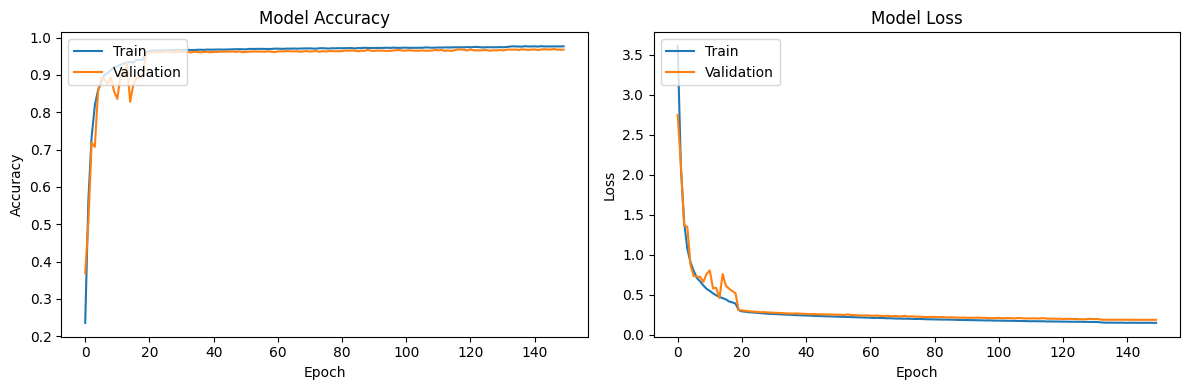

Test Loss: 0.1836
Test Accuracy: 0.9680
Top-1 Error: 0.0320
Top-5 Error: 0.0183

Classification Report:
              precision    recall  f1-score   support

    accident       0.99      0.96      0.97        98
       apple       1.00      1.00      1.00       115
       argue       0.98      0.98      0.98        85
         bad       1.00      0.94      0.97        63
     balance       0.95      0.98      0.97       100
         bar       1.00      0.96      0.98        95
  basketball       1.00      0.99      0.99        92
     because       1.00      0.98      0.99        56
         bed       0.96      1.00      0.98        76
      before       0.97      0.92      0.94       102
        bird       1.00      0.98      0.99        85
       black       0.98      0.94      0.96        68
     blanket       1.00      0.95      0.98        63
     bowling       1.00      0.99      0.99        76
     brother       0.99      0.98      0.98        86
        call       1.00      1.

In [ ]:
from sklearn.metrics import top_k_accuracy_score

# Get predictions on the test set
y_pred = model.predict(X_test)

# Calculate Top-1 Error
top1_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
top1_error = 1 - top1_accuracy

# Calculate Top-5 Error
top5_accuracy = top_k_accuracy_score(np.argmax(y_test, axis=1), y_pred, k=5)
top5_error = 1 - top5_accuracy

# If you want to plot the training history including these metrics:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Print final evaluation metrics
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Top-1 Error: {top1_error:.4f}")
print(f"Top-5 Error: {top5_error:.4f}")

# If you want to see per-class accuracy:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)